<a href="https://colab.research.google.com/github/fedrianMF/Robot-Trading/blob/main/Challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. CONFIGURACION DE AMBIENTE

###1.1. Declaracion de Variables Globales

In [1]:
df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision = [], 0.0, '', 0.0, ''

###1.2. Verificacion de Librerias

In [2]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'
print('------')
!pip show yfinance | grep 'Name\|Version'

Python 3.10.11
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.22.4
------
Name: matplotlib
Version: 3.7.1
------
Name: yfinance
Version: 0.2.18


#2. OBTENCION DE DATOS

###2.1. Importamos librerias necesarias

In [3]:
import yfinance as yf
import requests
import time
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from datetime import datetime
from IPython.display import clear_output

###2.2. Crear funcion importar_base_bitcoin

In [4]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision 
  ticker = "BTC-USD"
  stock = yf.Ticker(ticker)
  df_bitcoin = stock.history(period="7d", interval="5m")

importar_base_bitcoin()
df_bitcoin

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-12 00:00:00+00:00,26987.662109,27006.585938,26987.662109,26990.148438,0,0.0,0.0
2023-05-12 00:05:00+00:00,26993.667969,26993.667969,26977.453125,26977.453125,0,0.0,0.0
2023-05-12 00:10:00+00:00,26974.347656,26974.347656,26965.638672,26965.835938,0,0.0,0.0
2023-05-12 00:15:00+00:00,26966.916016,27005.796875,26965.488281,26971.810547,0,0.0,0.0
2023-05-12 00:20:00+00:00,26971.177734,27001.156250,26971.177734,27001.156250,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-18 17:25:00+00:00,27033.425781,27056.708984,27017.191406,27017.191406,14274560,0.0,0.0
2023-05-18 17:30:00+00:00,27031.281250,27031.281250,26992.472656,27019.310547,73997312,0.0,0.0
2023-05-18 17:35:00+00:00,27016.759766,27016.759766,26888.537109,26888.537109,46410752,0.0,0.0


###2.3. Crear funcion extraer_tendencias

In [5]:
def extraer_tendencias():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision 
  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36 Edg/113.0.1774.42'}
  url = 'https://coinmarketcap.com/'
  response = requests.get(url, headers = headers)
  soup = BeautifulSoup(response.content, 'html.parser')
  bitcoin_row = soup.find('table').tbody.tr
  precio_actual = float(bitcoin_row.findAll('td')[3].find('span').getText().replace(',','').replace('$',''))
  tendencia = 'Baja' if 'icon-Caret-down' in bitcoin_row.findAll('td')[4].find('span').span.get('class') else 'Baja'
  #tendencia_local = bitcoin_row.findAll('td')[4].find('span').getText().replace('%','')

extraer_tendencias()
print(str(precio_actual), tendencia)

26718.35 Baja


#3. LIMPIEZA DE DATOS

###3.1. Crear funcion limpieza_datos

In [6]:
def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision 
  df_bitcoin_limpio = df_bitcoin.copy()
  indices_duplicados = df_bitcoin_limpio.index.duplicated()
  df_bitcoin_limpio = df_bitcoin_limpio[~indices_duplicados]
  df_bitcoin_limpio['Close'].fillna(0, inplace=True)
  if not (df_bitcoin_limpio['Volume'] > 0).all():
      df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  # Calcular el rango intercuartil (IQR)
  Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
  IQR = Q3 - Q1

  # Definir los umbrales para identificar outliers
  umbral_inferior = Q1 - 1.5 * IQR
  umbral_superior = Q3 + 1.5 * IQR

  df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= umbral_inferior) & (df_bitcoin_limpio['Close'] <= umbral_superior)]
  df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)]
  media_bitcoin = df_bitcoin_limpio['Close'].mean()

limpieza_datos()
media_bitcoin

26984.530598958332

#4. TOMAR DECISIONES

###4.1. Crear funcion tomar_decisiones

In [7]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision 
  if (precio_actual >= media_bitcoin) and (tendencia == 'Baja'):
    algoritmo_decision = 'Vender'
  elif (precio_actual < media_bitcoin) and (tendencia == 'Alta'):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = ''

tomar_decisiones()
algoritmo_decision

''

#5. VISUALIZACION

###5.1. crear funcion visualizacion

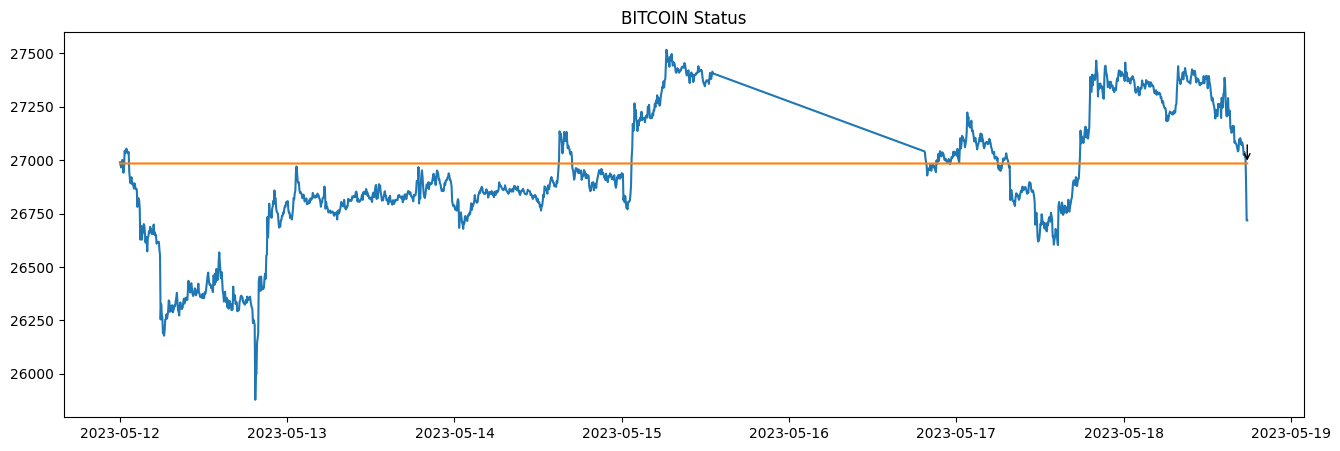

In [8]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision 
  df_bitcoin['Promedio'] = media_bitcoin #Adicionar columna Promedio
  fig = plt.figure(figsize=(16, 5)) #Tamaño grafico
  ax = fig.add_subplot(1, 1, 1) 
  ax.set_title("BITCOIN Status") #Titulo Grafico
  ax.plot(df_bitcoin.index, df_bitcoin["Close"]) # Funcion de Close
  ax.plot(df_bitcoin.index, df_bitcoin["Promedio"]) # Funcion de Promedio
  plt.annotate(algoritmo_decision, xy=(df_bitcoin.index[-1], df_bitcoin["Promedio"][-1]), xytext=(df_bitcoin.index[-1], df_bitcoin["Promedio"][-1]+100),
              arrowprops=dict(arrowstyle="->")) #Mostrar Mensaje
  plt.show()# Mostrar el gráfico

visualizacion()

#6. AUTOMATIZACION

###6.1. Loop

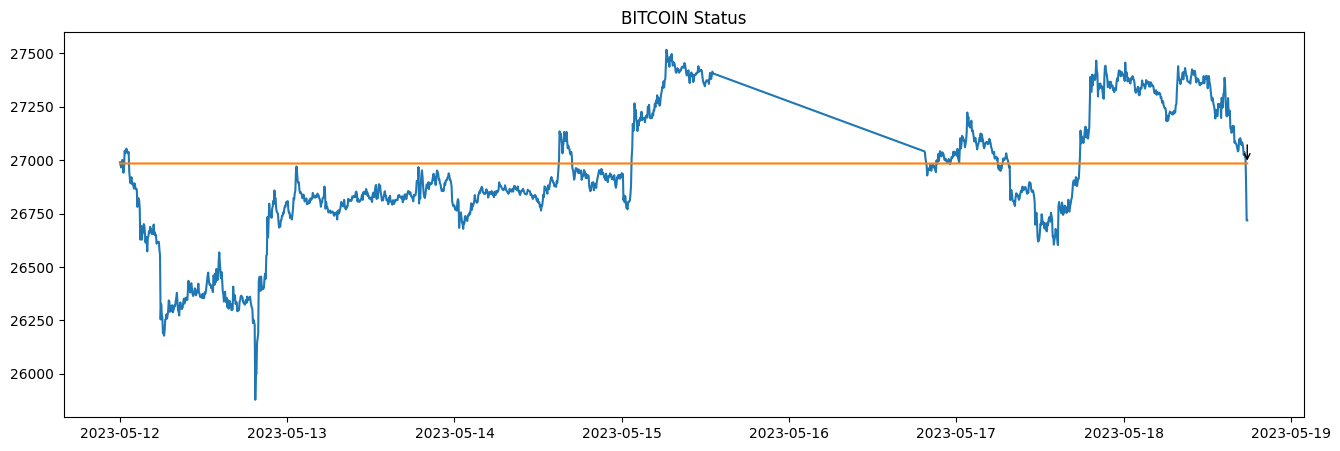

KeyboardInterrupt: ignored

In [9]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(10)